<a href="https://colab.research.google.com/github/ashishtrivedi16/major_project_stuff/blob/master/models/fingerprint_inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# GPU details
!nvidia-smi

In [0]:
# CPU details
!cat /proc/cpuinfo

In [0]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''
Mount your gdrive account by running this cell and place your database files
in it for easy access.
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os # for basic operations like folder creation, directory validation etc
import glob # finds file according to wildcard given
import shutil # for moving files
import matplotlib.pyplot as plt # for plotting graphs and viewing images

In [0]:
'''
This function organises fingerprint of a person to his respective folder
No need to run this cell as i've already organised the images into their
respective folders
'''

src = "./drive/My Drive/dbs/DB2_B/dataset/"
des = "./drive/My Drive/dbs/DB2_B/dataset/"
def organise_files(path=src):
    for i in range(101, 111):
        if not os.path.isdir(src + str(i)):
            os.makedirs(src + str(i))
        for name in glob.glob(src + str(i) + "_*.tif"):
            shutil.move(name, des + str(i) )

organise_files()            

In [0]:
'''
Visualise file directory structure
'''

startpath = './drive/My Drive/dbs/DB4_B'

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

list_files(startpath)

In [0]:
'''
function to divide the dataset into train and test folders for 
ImageDataGenerator.flow_from_directory() function

train set -> 75% (6 fingerprints per person)
validation set -> 25% (2 fingerprints per person)
'''
import random

startpath = './drive/My Drive/dbs/DB2_B/'
train_split = 0.75
validation_split = 0.25

def train_validation_split(startpath, train=train_split, validation=validation_split):
    # first create same sub-diretory structure in both train and validation folders
    dir_list  = [x[1] for x in os.walk(startpath + 'dataset')][0]
    for dir in dir_list:
        if not os.path.isdir(startpath + 'train/' + dir):
            os.mkdir(startpath + 'train/' + dir)
        if not os.path.isdir(startpath + 'validation/' + dir):
            os.mkdir(startpath + 'validation/' + dir)

    # randomly select images based on train validation slipt and move them
    # to their respective folders
    for root_dir in [x[0] for x in os.walk(startpath + 'dataset')][1:]:
        # get the list of files in respective subdirectories
        filename_list = [x[2] for x in os.walk(root_dir)][0]
        
        # randomly select files for train set
        train_file_length = float(len(filename_list)) * train
        filenames = random.sample(filename_list, int(train_file_length))
        for fname in filenames:
            filename_list.remove(fname) # rest files will go in validation set
            src = os.path.join(root_dir, fname)
            dest = os.path.join(startpath + 'train/' + fname[0:3], fname)
            shutil.copyfile(src, dest)

        # move rest of the files to validation set
        for fname in filename_list:
            src = os.path.join(root_dir, fname)
            dest = os.path.join(startpath + 'validation/' + fname[0:3], fname)
            shutil.copyfile(src, dest)

train_validation_split(startpath)

In [9]:
!pip install --upgrade pillow

     |████████████████████████████████| 2.1MB 31.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [8]:
'''
-> Generator class for applying image transformations
-> Can be used for image augmentation purposes if need be
-> Currently just normalises the image
-> tensorflow does not support importing and processing images
    so use this or use PIL(python image library)
'''

from keras.models import Model
from keras import backend as K
from keras.layers import Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

# ImageFile.LOAD_TRUNCATED_IMAGES = True

# Image dimension data
'''
    Sensor Type	    Image Size	            Set A	Set B	Resolution
DB1	Optical Sensor	640x480 (307 Kpixels)	100x8	10x8	500 dpi
DB2	Optical Sensor	328x364 (119 Kpixels)	100x8	10x8	500 dpi
DB3	Thermal sweeping
    Sensor	        300x480 (144 Kpixels)	100x8	10x8	512 dpi
DB4	SFinGe v3.0	    288x384 (108 Kpixels)	100x8	10x8	about 500 dpi
'''

img_width, img_height = 640, 480
train_data_dir = './drive/My Drive/dbs/DB1_B/train'
validation_data_dir = './drive/My Drive/dbs/DB1_B/validation'
nb_train_samples = 60
nb_validation_samples = 20
batch_size = 5
epochs = 150

if K.image_data_format() == 'channels_last':
    input_tensor = Input(shape=(img_width, img_height, 3))
else:
    input_tensor = Input(shape=(3, img_width, img_height))


train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        './drive/My Drive/dbs/DB1_B/train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        './drive/My Drive/dbs/DB1_B/validation',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

# imports the inceptionv3 pretained model
inception_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inception_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers
for layer in inception_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy')
# model.summary()

history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size
        )

Found 60 images belonging to 10 classes.
Found 20 images belonging to 10 classes.
Epoch 1/150
11/12 [==========================>...] - ETA: 0s - loss: 3.4319

OSError: ignored

In [0]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

dict_keys(['loss'])


KeyError: ignored

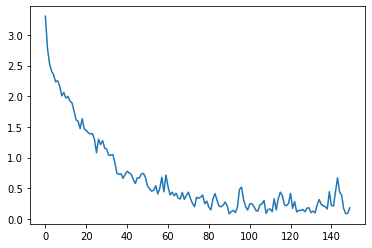

In [8]:
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
im = Image.open("./drive/My Drive/dbs/DB1_B/validation/110/110_6.tiff")


OSError: ignored

In [0]:
im.show()